In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers.legacy import Adam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#  Building our Model To train the data 

In [70]:
# Working with pre trained model 

base_model = MobileNet( input_shape=(224,224,3), include_top= False )

for layer in base_model.layers:
  layer.trainable = False

# 
# x = Flatten()(base_model.output)
# x = Dense(units=7 , activation='softmax' )(x)

# Add new layers
x = Flatten()(base_model.output)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(units=7, activation='softmax')(x)

# creating our model.
model = Model(base_model.input, x)

In [71]:
optimizer = Adam(learning_rate=0.001)

In [72]:
model.compile(optimizer=optimizer, loss= categorical_crossentropy , metrics=['accuracy']  )

# Preparing our data using data generator

In [73]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2, 
     shear_range = 0.2, 
     horizontal_flip=True, 
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "dataset/train", 
                                               target_size=(224,224), 
                                               batch_size=32,
                                  )


train_data.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [74]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "dataset/test", 
                                           target_size=(224,224), 
                                           batch_size=32,
                                  )

Found 7178 images belonging to 7 classes.


# visualizaing the data that is fed to train data gen

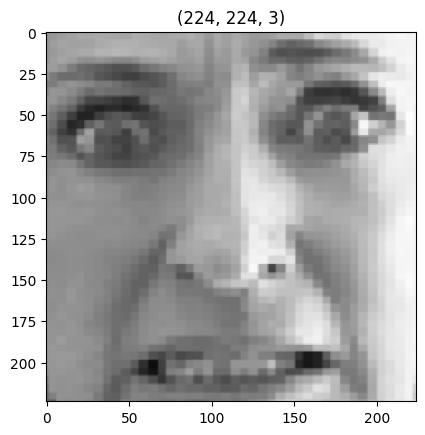

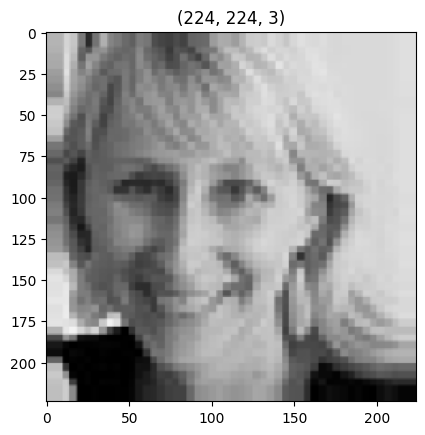

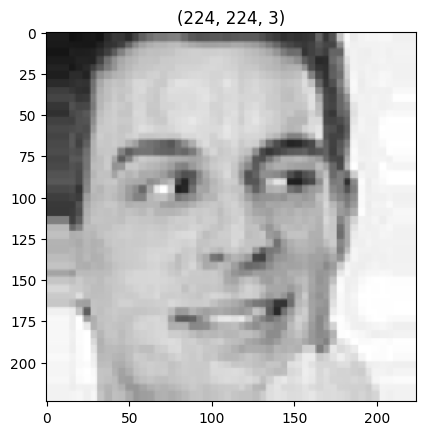

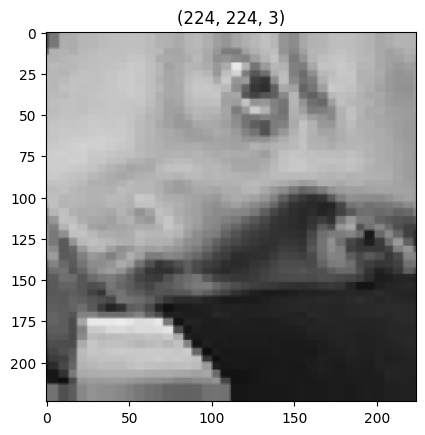

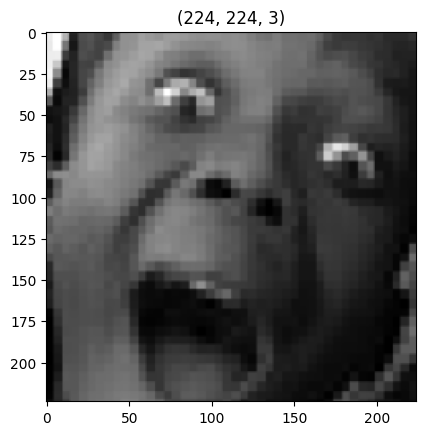

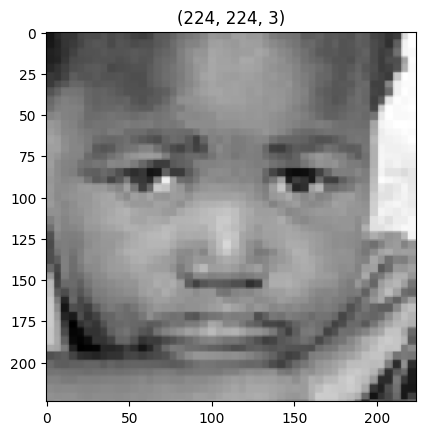

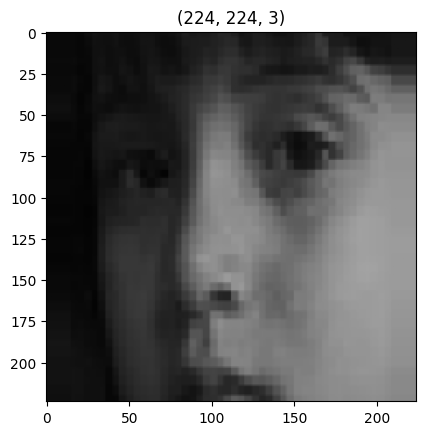

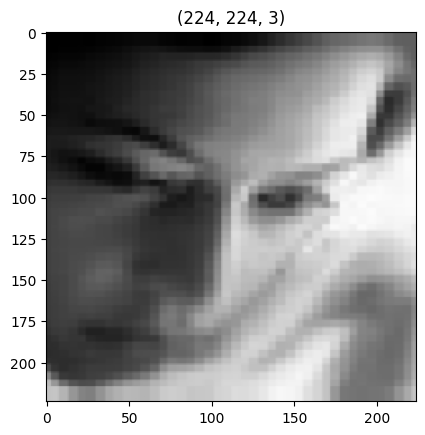

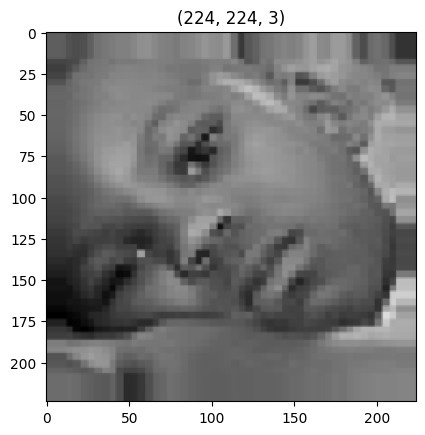

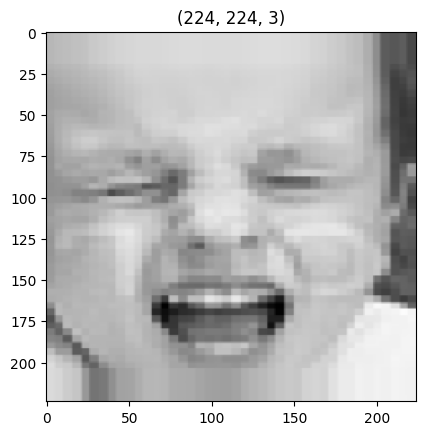

In [75]:
# to visualize the images in the traing data denerator 

t_img , label = train_data.next()

#-----------------------------------------------------------------------------
# function when called will prot the images 
def plotImages(img_arr, label):
  """
  input  :- images array 
  output :- plots the images 
  """
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    
    count += 1
    if count == 10:
      break

#-----------------------------------------------------------------------------
# function call to plot the images 
plotImages(t_img, label)

# having early stopping and model check point

In [76]:
## having early stopping and model check point 

# from keras.callbacks import ModelCheckpoint, EarlyStopping
# 
# # early stopping
# es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')
# 
# # model check point
# mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')
# 
# # puting call back in a list 
# call_back = [es, mc]

In [77]:
# hist = model.fit(train_data, 
#                            steps_per_epoch= 10, 
#                            epochs= 30, 
#                            validation_data= val_data, 
#                            validation_steps= 8, 
#                            callbacks=[es,mc])

In [78]:
# Define the callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=5, verbose=1, mode='auto')
model_checkpoint = ModelCheckpoint(filepath="best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, mode='auto')

callbacks = [early_stopping, model_checkpoint]


In [79]:
# Train the model
hist = model.fit(train_data,
                           steps_per_epoch=len(train_data),
                           epochs=30,
                           validation_data=val_data,
                           validation_steps=len(val_data),
                           callbacks=callbacks)

Epoch 1/30
898/898 [==============================] - ETA: 0s - loss: 1.4393 - accuracy: 0.4728
Epoch 1: val_accuracy improved from -inf to 0.55991, saving model to best_model.h5
898/898 [==============================] - 205s 227ms/step - loss: 1.4393 - accuracy: 0.4728 - val_loss: 1.1642 - val_accuracy: 0.5599
Epoch 2/30
898/898 [==============================] - ETA: 0s - loss: 1.1980 - accuracy: 0.5536
Epoch 2: val_accuracy improved from 0.55991 to 0.58470, saving model to best_model.h5
898/898 [==============================] - 196s 218ms/step - loss: 1.1980 - accuracy: 0.5536 - val_loss: 1.1120 - val_accuracy: 0.5847
Epoch 3/30
898/898 [==============================] - ETA: 0s - loss: 1.1271 - accuracy: 0.5805
Epoch 3: val_accuracy improved from 0.58470 to 0.59390, saving model to best_model.h5
898/898 [==============================] - 195s 217ms/step - loss: 1.1271 - accuracy: 0.5805 - val_loss: 1.0969 - val_accuracy: 0.5939
Epoch 4/30
898/898 [==============================] 

In [80]:
predictions = model.predict(val_data)

225/225 [==============================] - 35s 155ms/step


In [81]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(val_data, predictions))

ValueError: Found input variables with inconsistent numbers of samples: [225, 7178]

In [82]:

# Loading the best fit model 
from keras.models import load_model
model = load_model("best_model.h5")

In [83]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

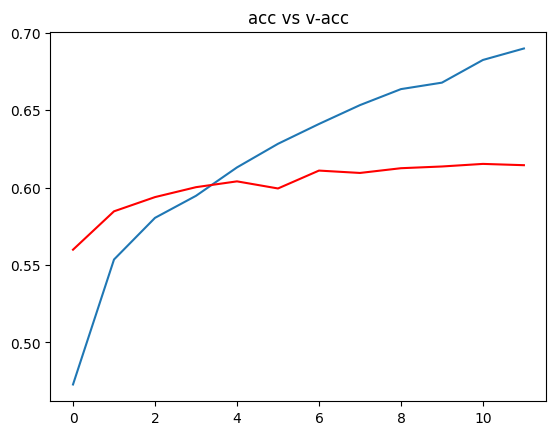

In [84]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

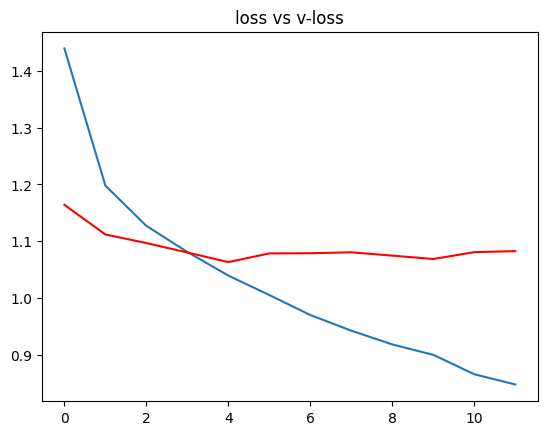

In [85]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [86]:
# just to map o/p values 
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))

1/1 [==============================] - 0s 174ms/step
 the image is of sad


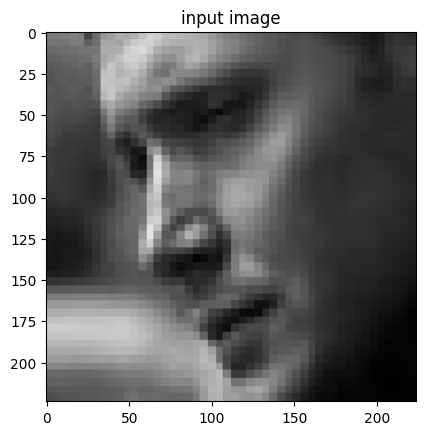

In [87]:
# path for the image to see if it predics correct class

path = "dataset/test/angry/PrivateTest_1054527.jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image  
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()